<a href="https://colab.research.google.com/github/JankaUhrinova/Assessing-Unsupervised-Pretraining-for-improving-prediction-in-Digital-Pathology/blob/main/all_methods_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import tensorflow as tf
import torchvision
import torch.nn.functional as F

In [ ]:
torch.manual_seed(0)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torch.utils.data import random_split

In [ ]:
transform=transforms.Compose([
    transforms.Resize([28,28]),
    transforms.ToTensor(),
    ])

In [ ]:
dataset = torchvision.datasets.ImageFolder("/content/drive/MyDrive/bakalarka/NCT-CRC-HE-100K/NCT-CRC-HE-100K/", transform)

In [ ]:
pretraining_data, training_data_20, training_data_15, training_data_7, training_data_5, training_data_2, training_data_1, testing_data = random_split(dataset, [30000, 20000, 15000, 7000, 5000, 2000, 1000, 20000])                                                                                                                                                                                                                                                                                                                                         

In [ ]:
#set tu True if you want to pretrain the autoencoders with different amounts of unlabelled data from 1000 to 30000
pretraining_mode = False

#set to True if you want to retrain pretrained autoencoders with training datasets
retraining_mode = False

#set to True if you want to train a classifiers with training datasets using a pretrained encoder
train_pretrained = False

#set to True if you want to train a classifier with training datasets without a pretrained encoder
train_nonpretrained = False

#set to True if you want to test and compare all the trained models 
test_mode = True

Encoder is a model that will serve as the encoder for the AutoEncoder as well as a part of the new classifiers.

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(3, 32, kernel_size = 3, stride = 2, padding = 1)
        self.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)
        self.fc = nn.Linear(12544, 9)
    
    def forward(self, x):
        x = x.view(-1, 3, 28, 28)
        x = F.leaky_relu(self.conv0(x))
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(9, 256*7*7)
        self.trans_conv1 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.trans_conv2 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.trans_conv3 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        self.trans_conv4 = nn.ConvTranspose2d(32, 3, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
    
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 7, 7)
        x = F.relu(self.trans_conv1(x))
        x = F.relu(self.trans_conv2(x))
        x = F.relu(self.trans_conv3(x))
        x = self.trans_conv4(x)
        x = torch.tanh(x)
        
        return x 

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, Encoder, Decoder):
        super().__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def forward(self, x):
        x = self.Encoder(x)
        x = self.Decoder(x)
        return x

In [ ]:
class Classifier(nn.Module):
    def __init__(self, Encoder):
        super().__init__()
        self.Encoder = Encoder
        self.fc1 = nn.Linear(9, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 9)

    def forward(self, x):
        x = self.Encoder(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

Training code that used for training the AutoEncoder -> pretraining the classifier.

In [ ]:
loss_function_pretraining = nn.MSELoss(reduction = 'sum')

In [ ]:
def train_AutoEncoder(model, optimizer, dataloader, epochs = 10):
  epochs = epochs
  losses = []
  for epoch in range(epochs):
      epoch_loss = 0
      print(epoch)
      i = 0
      for data in dataloader:
        if(epoch == 0 and i % 10 == 0):
          print(i)
        i += 1
        data_img = data[0]*2 - 1
        data_img = data_img.to(device)
        reconstructed = model(data_img)
        
        loss = loss_function_pretraining(reconstructed, data_img)
        epoch_loss += loss.detach().cpu().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
      losses.append(epoch_loss)
  
  return np.array(losses)


In [ ]:
# untrained AE for visualisation

e = Encoder().to(device).float()
d = Decoder().to(device).float()
ae = AutoEncoder(e,d).to(device).float()

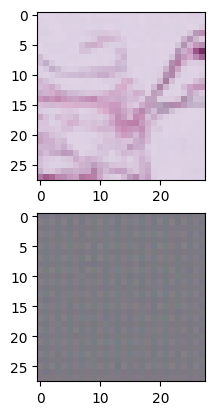

In [ ]:
fig, axs = plt.subplots(2)
 
# Reshape the array for plotting
image = pretraining_data[3][0]
axs[0].imshow(image.permute(1, 2, 0))
image = image*2-1
image = image.to(device)
#print(image)
recon = ae(image)
#print(recon)
recon = (recon+1)/2
recon = recon.cpu().detach().reshape([3,28,28])
# print(recon)
# print(tf.shape(recon))
axs[1].imshow(recon.permute(1, 2, 0))

In [ ]:
if pretraining_mode:

  # Defining the Plot Style
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  
  for size in [1000, 3000, 10000, 20000, 30000]:
    dataset = torch.utils.data.Subset(pretraining_data, range(size))
    dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)
    encoder = Encoder().to(device).float()
    decoder = Decoder().to(device).float()
    autoencoder = AutoEncoder(encoder,decoder).to(device).float()
    losses = train_AutoEncoder(autoencoder, optim.Adam(autoencoder.parameters(), lr = 0.0002), dataloader, 10)
    torch.save(encoder.state_dict(), f"/content/drive/MyDrive/bakalarka/trained_models/trainedencoder{size}.pt")
    torch.save(autoencoder.state_dict(), f"/content/drive/MyDrive/bakalarka/trained_models/trainedautoencoder{size}.pt")
    plt.plot(losses/size, label = size)
    plt.legend()

Preparing dataloaders for training and testing and a training function:

In [ ]:
training20_dataloader = DataLoader(training_data_20, batch_size = 32, shuffle = True)
training15_dataloader = DataLoader(training_data_15, batch_size = 32, shuffle = True)
training7_dataloader = DataLoader(training_data_7, batch_size = 32, shuffle = True)
training5_dataloader = DataLoader(training_data_5, batch_size = 32, shuffle = True)
training2_dataloader = DataLoader(training_data_2, batch_size = 32, shuffle = True)
training1_dataloader = DataLoader(training_data_1, batch_size = 32, shuffle = True)
testing_dataloader = torch.utils.data.DataLoader(testing_data, shuffle = True)

In [ ]:
dataloader_labels = { training1_dataloader : 1,
    training2_dataloader : 2,
    training5_dataloader : 5,
    training7_dataloader : 7,
    training15_dataloader : 15,
    training20_dataloader : 20,
}

In [ ]:
loss_function_training = nn.CrossEntropyLoss()

In [ ]:
def training(model, optimizer, dataloader, epochs = 10):
    for epoch in range(1, epochs + 1):
        loss_train = 0.0
        i  = 0
        for imgs, labels in dataloader:
            if (epoch == 1 and i%10 == 0):
              print(i)
            i += 1
            outputs = model(imgs.to(device))
            loss = loss_function_training(outputs, labels.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()

        print('Epoch {}, Training loss {}'.format(
            epoch, float(loss_train)/len(dataloader.dataset)))



# Re-training of the encoder.

Function that re-trains the pre-trained enocder as a classifier on datasets of different sizes. 

In [ ]:
from os.path import exists

In [ ]:
if retraining_mode:
  for size in [1000, 3000, 10000, 20000, 30000]:
    for loader in [training1_dataloader, training2_dataloader, training5_dataloader, training7_dataloader, training15_dataloader, training20_dataloader]:
      #The following line checks if the model has already been trained and if so skips is. If you wish to rewrite the state dictionary with a new trained model, comment the next two lines out.
      if exists(f"/content/drive/MyDrive/bakalarka/trained_models/retrained_encoders/retrained{size}_{dataloader_labels[loader]}.pt"):
        continue
      
      print(size, dataloader_labels[loader])
      #loading of a pretrained encoder
      model = Encoder().to(device).float()
      model.load_state_dict(torch.load(f"/content/drive/MyDrive/bakalarka/trained_models/trainedencoder{size}.pt"))

      #retraining of a pretrained encoder into a classifier
      training(model, optim.Adam(model.parameters(), lr = 0.0002), loader, 10)
      torch.save(model.state_dict(), f"/content/drive/MyDrive/bakalarka/trained_models/retrained_encoders/retrained{size}_{dataloader_labels[loader]}.pt")

# Training of the classifier using a pre-trained encoder.



In [ ]:
if train_pretrained:
  for size in [1000, 3000, 10000, 20000, 30000]:
    for loader in [training1_dataloader, training2_dataloader, training5_dataloader, training7_dataloader, training15_dataloader, training20_dataloader]:
      #The following line checks if the model has already been trained and if so skips is. If you wish to rewrite the state dictionary with a new trained model, comment the next two lines out.
      if exists(f"/content/drive/MyDrive/bakalarka/trained_models/pretrained_classifiers/pretrained{size}_{dataloader_labels[loader]}.pt"):
        continue

      #loading a pretrained encoder and passing it to the new classifier
      encoder = Encoder().to(device).float()
      encoder.load_state_dict(torch.load(f"/content/drive/MyDrive/bakalarka/trained_models/trainedencoder{size}.pt"))
      classifier = Classifier(encoder).to(device).float()
      
      #freezing the pretrained encoder for the training part
      for name, param in classifier.named_parameters():
        if param.requires_grad and 'Encoder' in name:
            param.requires_grad = False
      non_frozen_parameters = [p for p in classifier.parameters() if p.requires_grad]

      #training of the classifier
      optimizer = optim.Adam(non_frozen_parameters, lr= 0.0002)
      training(classifier, optimizer, loader, 10)
      torch.save(classifier.state_dict(), f"/content/drive/MyDrive/bakalarka/trained_models/pretrained_classifiers/pretrained{size}_{dataloader_labels[loader]}.pt")

# Training of the classifier without pretraining

In [ ]:
if train_nonpretrained:
  for loader in [training1_dataloader, training2_dataloader, training5_dataloader, training7_dataloader, training15_dataloader, training20_dataloader]:
    #The following line checks if the model has already been trained and if so skips is. If you wish to rewrite the state dictionary with a new trained model, comment the next two lines out.
    if exists( f"/content/drive/MyDrive/bakalarka/trained_models/nonpretrained_classifiers/classifier{dataloader_labels[loader]}.pt"):
      continue
      
    encoder = Encoder().to(device).float()
    classifier = Classifier(encoder).to(device).float()

    #training of the classifier
    optimizer = optim.Adam(classifier.parameters(), lr= 0.0002)
    training(classifier, optimizer, loader, 10)
    torch.save(classifier.state_dict(), f"/content/drive/MyDrive/bakalarka/trained_models/nonpretrained_classifiers/classifier{dataloader_labels[loader]}.pt")

# Final testing and comparison of all models 

In [ ]:
def testing(model, dataloader):
    test_loss = 0
    correct = 0
    i = 0
    with torch.no_grad():
        for data, target in dataloader:
            if(i%100 == 0):
                print(i)
            i += 1
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_function_training(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(dataloader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(dataloader.dataset),
        100. * correct / len(dataloader.dataset)))
    
    return(100. * correct / len(dataloader.dataset))

In [ ]:
results = {
    1000 : [[] for i in range(3)],
    3000 : [[] for i in range(3)],
    10000 : [[] for i in range(3)],
    20000 : [[] for i in range(3)],
    30000 : [[] for i in range(3)],
}

In [ ]:
for size in [1000, 3000, 10000, 20000, 30000]:
  accuracy_retrained_encoder = []
  accuracy_pretrained_classifier = []
  accuracy_classifier = []

  print("Testing:", size)
  for loader in [training1_dataloader, training2_dataloader, training5_dataloader, training7_dataloader, training15_dataloader, training20_dataloader]:
    #loading of all 3 compared models
    retrained_encoder = Encoder().to(device).float()
    retrained_encoder.load_state_dict(torch.load(f"/content/drive/MyDrive/bakalarka/trained_models/retrained_encoders/retrained{size}_{dataloader_labels[loader]}.pt"))
    accuracy = testing(retrained_encoder, testing_dataloader)
    print(f"Encoder pretrained on {size} data and retrained on {dataloader_labels[loader]*1000} data. Accuracy")
    accuracy_retrained_encoder.append(accuracy)

    encoder = Encoder().to(device).float()
    pretrained_classifier = Classifier(encoder).to(device).float()
    pretrained_classifier.load_state_dict(torch.load(f"/content/drive/MyDrive/bakalarka/trained_models/pretrained_classifiers/pretrained{size}_{dataloader_labels[loader]}.pt"))
    accuracy = testing(pretrained_classifier, testing_dataloader)
    print(f"Classifier pretrained on {size} data and trained on {dataloader_labels[loader]*1000} data. Accuracy")
    accuracy_pretrained_classifier.append(accuracy)

    encoder = Encoder().to(device).float()
    classifier = Classifier(encoder).to(device).float()
    classifier.load_state_dict(torch.load(f"/content/drive/MyDrive/bakalarka/trained_models/nonpretrained_classifiers/classifier{dataloader_labels[loader]}.pt"))
    accuracy = testing(classifier, testing_dataloader)
    print(f"Classifier trained on {dataloader_labels[loader]*1000} data. Accuracy")
    accuracy_classifier.append(accuracy)

  results[size][0] = accuracy_retrained_encoder
  results[size][1] = accuracy_pretrained_classifier
  results[size][2] = accuracy_classifier
  
  

Streaming output truncated to the last 5000 lines.
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18500
18600
18700
18800
18900
19000
19100
19200
19300
19400
19500
19600
19700
19800
19900

Test set: Average loss: 1.2306, Accuracy: 10201/20000 (51%)

Classifier trained on 7000 data. Accuracy
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
520

In [ ]:
for size, result in results.items():
  print(result[0])
  print(result[1])
  print(result[2])

[53.5, 56.975, 58.5, 64.195, 69.24, 76.45]
[17.81, 16.53, 19.535, 24.445, 33.275, 33.24]
[38.775, 45.975, 57.25, 51.005, 69.205, 67.62]
[55.68, 49.075, 59.15, 68.13, 73.755, 77.425]
[16.685, 32.99, 36.34, 43.92, 48.93, 48.64]
[38.775, 45.975, 57.25, 51.005, 69.205, 67.62]
[52.095, 58.665, 53.965, 65.715, 74.59, 77.24]
[10.7, 25.02, 32.87, 43.37, 47.075, 49.6]
[38.775, 45.975, 57.25, 51.005, 69.205, 67.62]
[54.79, 61.35, 64.015, 69.815, 77.145, 80.105]
[18.53, 27.61, 37.525, 41.045, 44.075, 46.685]
[38.775, 45.975, 57.25, 51.005, 69.205, 67.62]
[54.205, 50.12, 63.02, 68.83, 75.255, 79.355]
[21.545, 21.185, 32.57, 34.035, 43.005, 42.505]
[38.775, 45.975, 57.25, 51.005, 69.205, 67.62]


In [ ]:
yaxis = [1000, 2000, 5000, 7000, 15000, 20000]

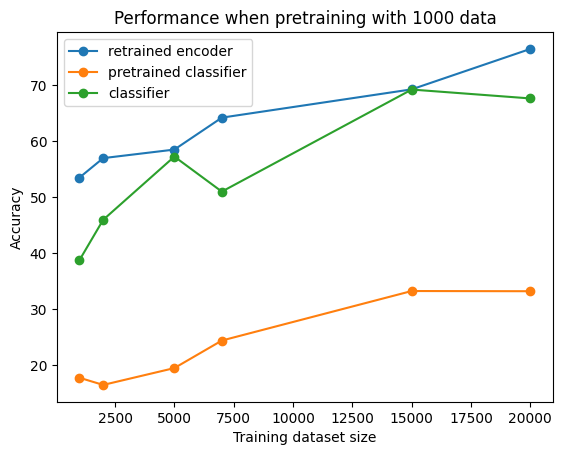

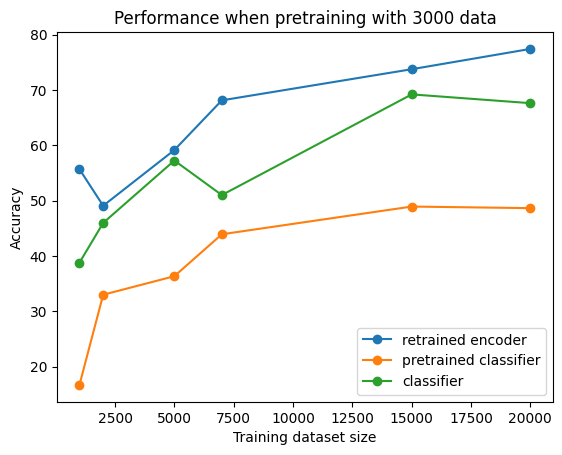

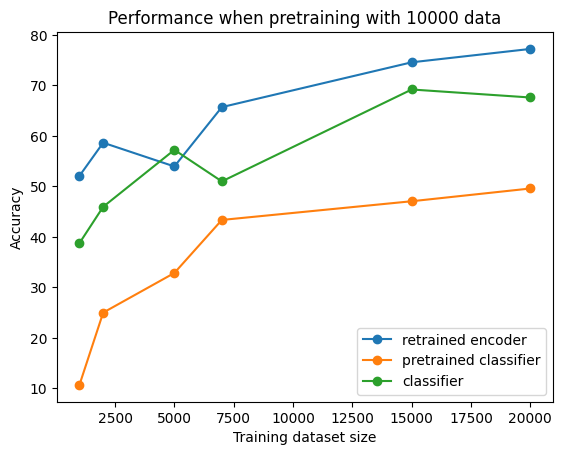

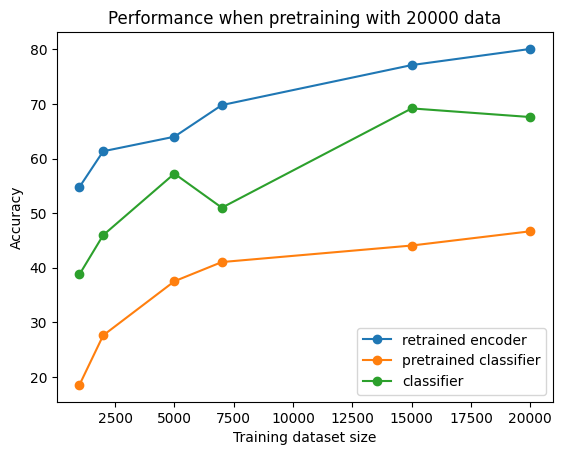

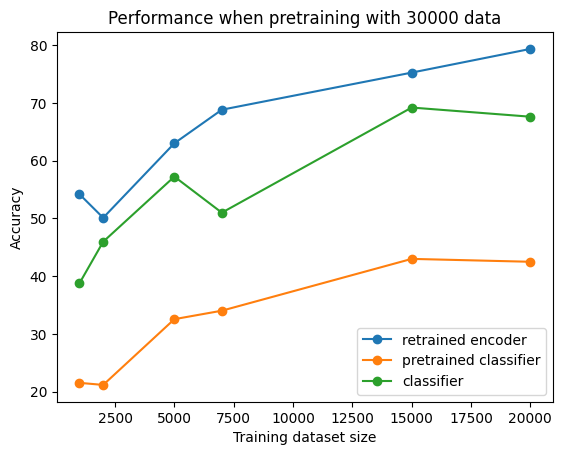

In [ ]:
for size, result in results.items():
  plt.xlabel('Training dataset size')
  plt.ylabel('Accuracy')
  plt.title(f'Performance when pretraining with {size} data')
  plt.plot(yaxis, result[0], marker = 'o', label = "retrained encoder")
  plt.plot(yaxis, result[1], marker = 'o', label = "pretrained classifier")
  plt.plot(yaxis, result[2], marker = 'o', label = "classifier")
  plt.legend()
  plt.savefig(f'accuracies_{size}')
  plt.show()